In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Cardetails.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500.0,Diesel,Individual,Manual,First Owner,NaN,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000.0,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000.0,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000.0,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000.0,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
df.isnull().sum()

name                0
year                0
selling_price       0
km_driven         813
fuel                0
seller_type         0
transmission        0
owner               0
mileage          1011
engine           1008
max_power         215
torque            222
seats             221
dtype: int64

In [4]:
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,7.315000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.962649e+04,5.416719
std,4.044249,8.062534e+05,5.709282e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.825000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [5]:
if 'engine' in df.columns:
    df['engine'] = df['engine'].str.replace('CC', '', regex=False).str.strip()
    df['engine'] = pd.to_numeric(df['engine'], errors='coerce')

if 'max_power' in df.columns:
    df['max_power'] = df['max_power'].str.replace('bhp', '', regex=False).str.strip()
    df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')

if 'mileage' in df.columns:
    df['mileage'] = df['mileage'].str.replace('kmpl', '', regex=False).str.strip()
    df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

In [6]:
df['engine'] = df['engine'].fillna(df['engine'].median())
df['max_power'] = df['max_power'].fillna(df['max_power'].median())
df['mileage'] = df['mileage'].fillna(df['mileage'].median())

In [7]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500.0,Diesel,Individual,Manual,First Owner,19.30,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000.0,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000.0,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000.0,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000.0,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [8]:
df.select_dtypes(include='object').columns


Index(['name', 'fuel', 'seller_type', 'transmission', 'owner', 'torque'], dtype='object')

In [9]:
import pandas as pd
import re

def extract_torque_and_mean_rpm(torque_str):

    if pd.isna(torque_str) or torque_str == "":
        return None, None
    
    torque_str = str(torque_str)
    torque_nm = None
    mean_rpm = None
    
    # Extract torque value and unit
    torque_match = re.search(r'(\d+\.?\d*)\s*(Nm|kgm|KGM)', torque_str, re.IGNORECASE)
    if torque_match:
        torque_value = float(torque_match.group(1))
        unit = torque_match.group(2).lower()
        
        # Convert to Nm (1 kgm = 9.80665 Nm)
        if unit in ['kgm', 'kgm']:
            torque_nm = round(torque_value * 9.80665, 1)
        else:  # Nm
            torque_nm = torque_value
    
    # Extract RPM and calculate mean
    # Case 1: RPM range "1500-2500rpm"
    range_match = re.search(r'(\d+)\s*-\s*(\d+)\s*rpm', torque_str, re.IGNORECASE)
    if range_match:
        rpm_low = int(range_match.group(1))
        rpm_high = int(range_match.group(2))
        mean_rpm = (rpm_low + rpm_high) / 2
    else:
        # Case 2: Single RPM value "2000rpm"
        single_match = re.search(r'(\d+)\s*rpm', torque_str, re.IGNORECASE)
        if single_match:
            mean_rpm = float(single_match.group(1))
    
    return torque_nm, mean_rpm

# Apply to your dataframe
def apply_simple_torque_extraction(df):
    """Apply the extraction function to the dataframe"""
    results = df['torque'].apply(extract_torque_and_mean_rpm)
    
    # Create new columns
    df['torque_nm'] = results.apply(lambda x: x[0] if x else None)
    df['mean_rpm'] = results.apply(lambda x: x[1] if x else None)
    
    return df

# Apply the function
df = apply_simple_torque_extraction(df)

In [10]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,torque_nm,mean_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500.0,Diesel,Individual,Manual,First Owner,19.30,1248.0,74.00,190Nm@ 2000rpm,5.0,190.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000.0,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0,250.0,2000.0
2,Honda City 2017-2020 EXi,2006,158000,140000.0,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0,NaN,NaN
3,Hyundai i20 Sportz Diesel,2010,225000,127000.0,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0,219.7,2250.0
4,Maruti Swift VXI BSIII,2007,130000,120000.0,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0,NaN,NaN


In [11]:
def preprocess_car_data(df):
    """Preprocess categorical features for car dataset"""
    
    # Create a copy
    df_processed = df.copy()
    
    # 1. LABEL ENCODING (ordinal/high cardinality)
    # Transmission
    df_processed['transmission_encoded'] = df_processed['transmission'].map({'Manual': 0, 'Automatic': 1})
    
    # Owner (with logical order)
    owner_mapping = {
        'First Owner': 0,
        'Second Owner': 1, 
        'Third Owner': 2,
        'Fourth & Above Owner': 3
    }
    df_processed['owner_encoded'] = df_processed['owner'].map(owner_mapping)
    
    # Seller Type
    seller_mapping = {
        'Individual': 0,
        'Dealer': 1,
        'Trustmark Dealer': 2
    }
    df_processed['seller_type_encoded'] = df_processed['seller_type'].map(seller_mapping)
    
    # 2. ONE-HOT ENCODING (nominal) - Convert to 0/1
    fuel_dummies = pd.get_dummies(df_processed['fuel'], prefix='fuel')
    fuel_dummies = fuel_dummies.astype(int)  # Convert True/False to 1/0
    
    # Concatenate with main dataframe
    df_processed = pd.concat([df_processed, fuel_dummies], axis=1)
    
    # Drop original categorical columns
    df_processed = df_processed.drop(['transmission', 'owner', 'seller_type', 'fuel'], axis=1)
    
    return df_processed

# Apply preprocessing
df_processed = preprocess_car_data(df)

In [12]:
df_processed.head()

,name,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,torque_nm,mean_rpm,transmission_encoded,owner_encoded,seller_type_encoded,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol
0,Maruti Swift Dzire VDI,2014,450000,145500.0,19.30,1248.0,74.00,190Nm@ 2000rpm,5.0,190.0,2000.0,0,0.0,0,0,1,0,0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000.0,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0,250.0,2000.0,0,1.0,0,0,1,0,0
2,Honda City 2017-2020 EXi,2006,158000,140000.0,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0,NaN,NaN,0,2.0,0,0,0,0,1
3,Hyundai i20 Sportz Diesel,2010,225000,127000.0,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0,219.7,2250.0,0,0.0,0,0,1,0,0
4,Maruti Swift VXI BSIII,2007,130000,120000.0,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0,NaN,NaN,0,0.0,0,0,0,0,1


In [13]:
Y=df_processed['selling_price']
X=df_processed.drop(['name','torque','selling_price'],axis=1)

In [14]:
X

,year,km_driven,mileage,engine,max_power,seats,torque_nm,mean_rpm,transmission_encoded,owner_encoded,seller_type_encoded,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol
0,2014,145500.0,19.30,1248.0,74.00,5.0,190.0,2000.0,0,0.0,0,0,1,0,0
1,2014,120000.0,21.14,1498.0,103.52,5.0,250.0,2000.0,0,1.0,0,0,1,0,0
2,2006,140000.0,17.70,1497.0,78.00,5.0,NaN,NaN,0,2.0,0,0,0,0,1
3,2010,127000.0,23.00,1396.0,90.00,5.0,219.7,2250.0,0,0.0,0,0,1,0,0
4,2007,120000.0,16.10,1298.0,88.20,5.0,NaN,NaN,0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,2013,110000.0,18.50,1197.0,82.85,5.0,113.7,4000.0,0,0.0,0,0,0,0,1
8124,2007,119000.0,16.80,1493.0,110.00,5.0,NaN,NaN,0,3.0,0,0,1,0,0
8125,2009,120000.0,19.30,1248.0,73.90,5.0,190.0,2000.0,0,0.0,0,0,1,0,0
8126,2013,25000.0,23.57,1396.0,70.00,5.0,140.0,2400.0,0,0.0,0,0,1,0,0


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [16]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model.fit(
    X_train, Y_train,
    eval_set=[(X_test, Y_test)],
    verbose=100
)

[0]	validation_0-rmse:734566.40167
[100]	validation_0-rmse:141430.17305
[200]	validation_0-rmse:138442.05533
[300]	validation_0-rmse:138499.40891
[400]	validation_0-rmse:138709.72532
[500]	validation_0-rmse:138968.45088
[600]	validation_0-rmse:139264.60449
[700]	validation_0-rmse:139525.80027
[800]	validation_0-rmse:139761.92565
[900]	validation_0-rmse:140177.06365
[999]	validation_0-rmse:140290.36444


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [17]:
y_pred = xgb_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred)

print(f"\nXGBoost Model Performance:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Approximate Average Error: {mae/Y_test.mean():.2%}")


XGBoost Model Performance:
MAE: $70370.23
MSE: $19681386496.00
RMSE: $140290.36
R² Score: 0.9700
Approximate Average Error: 11.05%


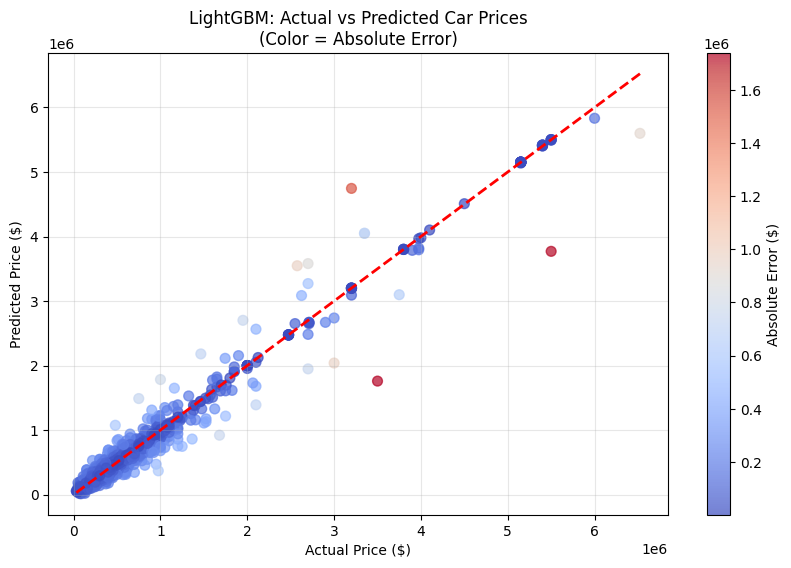

In [20]:
errors = np.abs(Y_test - y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.7, s=50)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.colorbar(label='Absolute Error ($)')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('LightGBM: Actual vs Predicted Car Prices\n(Color = Absolute Error)')
plt.grid(True, alpha=0.3)
plt.show()